## Importing necessary libraries

In [ ]:
import tensorflow as tf
import numpy as np
import re, os
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

## Getting data from Kaggle

In [ ]:
import requests
import pandas as pd
import tarfile
import os

# Define the URL for the IMDb sentiment analysis dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset_filename = "aclImdb_v1.tar.gz"

# Specify the download location
download_location = "./data/"

# Create the download directory if it doesn't exist
if not os.path.exists(download_location):
    os.makedirs(download_location)

# Download the dataset
response = requests.get(url)
with open(download_location + dataset_filename, 'wb') as f:
    f.write(response.content)

# Extract the downloaded file
with tarfile.open(download_location + dataset_filename, 'r:gz') as tar:
    tar.extractall(download_location)

# Define the path to the extracted dataset
dataset_path = download_location + "aclImdb/"

# Function to load the dataset into a Pandas DataFrame
def load_imdb_dataset(data_path):
    texts = []
    labels = []
    for category in ['train', 'test']:
        for sentiment in ['pos', 'neg']:
            folder_path = os.path.join(data_path, category, sentiment)
            for filename in os.listdir(folder_path):
                with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                    text = file.read()
                    texts.append(text)
                    labels.append(1 if sentiment == 'pos' else 0)
    return pd.DataFrame({'text': texts, 'label': labels})

# Load the dataset into a Pandas DataFrame
imdb_df = load_imdb_dataset(dataset_path)

# Display the first few rows of the DataFrame
print(imdb_df.head())


                                                text  label
0  I'm intrigued by the strong sense of favour to...      1
1  The best film on the battle of San Antonio, Te...      1
2  This is how i felt while watching this film. I...      1
3  While not as famous as some of their other col...      1
4  Unlike many other films, which are disturbing ...      1


In [ ]:
len(imdb_df)

50000

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, test, and validation sets
df_train, test_val_df = train_test_split(imdb_df, test_size=10000, random_state=42)
df_test, df_val = train_test_split(test_val_df, test_size=0.5, random_state=42)

# Display the shapes of the resulting DataFrames
print("Train set shape:", df_train.shape)
print("Test set shape:", df_test.shape)
print("Validation set shape:", df_val.shape)


Train set shape: (40000, 2)
Test set shape: (5000, 2)
Validation set shape: (5000, 2)


In [ ]:
df_val.head()

,text,label
25056,When I started watching 3 of the episodes of t...,1
30334,"Every time I watch this film, it just really m...",1
17962,"Oh Dear, Jerry may be the undisputed king of t...",0
39588,Very poor quality and the acting is equally as...,0
34107,"I couldn't stop watching this movie, though it...",1


In [ ]:
df_test.head()

,text,label
47374,"""The Vindicator"" is a weird little Canadian B-...",0
48216,"The parallels between this film and ""Captain W...",0
45929,When all we have anymore is pretty much realit...,0
48715,Sorry to say but was disappointed in the film....,0
18849,"The premise, while not quite ludicrous, WAS de...",0


In [ ]:
df_train['label'].value_counts()

0    20055
1    19945
Name: label, dtype: int64

## Preprocessing

In [ ]:
# Cleaning/Preprocessing Helper function

def preprocess(s):
  s = re.sub(r'@[a-zA-Z0-9_.]+ ', '', str(s))
  s = re.sub(r'#[a-zA-Z0-9_.]+ ', '', str(s))
  s = re.sub(r'''[^a-zA-Z0-9?. ]+''', '', s)
  s = re.sub(r''''[' ']+''', " ", s)
  s = re.sub(r'(\w)\1{2,}',r'\1',s)
  s = s.lower().strip()
  return s

In [ ]:
df_train['text'] = df_train['text'].apply(preprocess)
df_val['text'] = df_val['text'].apply(preprocess)
df_test['text'] = df_test['text'].apply(preprocess)

In [ ]:
def get_data(df):
  zeros, ones = df[df['label']==0], df[df['label']==1]
  zero_text, zero_labels = zeros['text'].to_numpy(), zeros['label'].to_numpy()
  one_text, one_labels = ones['text'].to_numpy(), ones['label'].to_numpy()
  X, Y = np.concatenate((one_text,zero_text)), np.concatenate((one_labels,zero_labels))
  return X,Y

In [ ]:
X_train,Y_train = get_data(df_train)
X_val,Y_val = get_data(df_val)
X_test,Y_test = get_data(df_test)

In [ ]:
X_train.shape,X_val.shape,X_test.shape

((40000,), (5000,), (5000,))

## Creating the Model

In [ ]:
# Instantiating the Tokenizer and creating sequences
tokenizer = tf.keras.preprocessing.text.Tokenizer(3000,oov_token=1)
tokenizer.fit_on_texts(X_train)
train_seq = tokenizer.texts_to_sequences(X_train)
val_seq = tokenizer.texts_to_sequences(X_val)
test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Padding all sequences
train_seq = tf.keras.preprocessing.sequence.pad_sequences(train_seq,maxlen=50,padding='post')
val_seq = tf.keras.preprocessing.sequence.pad_sequences(val_seq,maxlen=50,padding='post')
test_seq = tf.keras.preprocessing.sequence.pad_sequences(test_seq,maxlen=50,padding='post')

## Creating the Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, Bidirectional, GlobalMaxPooling1D, Dense, Dropout

def create_model():
    model = tf.keras.models.Sequential()
    model.add(Embedding(input_dim=3000, output_dim=128))

    # Convolutional layers
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))

    # Global Max Pooling layer
    model.add(GlobalMaxPooling1D())

    # Dense layers
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(units=1, activation='sigmoid'))

    model.summary()

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model


## Full Model Training

In [ ]:
# HELPER FUNCTION

def plot(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['train_loss','val_loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['train_accuracy','val_accuracy'])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

In [ ]:
def train_full_model(train_seq,Y_train,val_seq,Y_val,test_seq,Y_test):
  model = create_model()
  history = model.fit(train_seq,Y_train,256,15,validation_data=(val_seq,Y_val),callbacks=[tf.keras.callbacks.ModelCheckpoint('FullModelCheckpoint.h5',save_best_only=True,verbose=1),tf.keras.callbacks.EarlyStopping(patience=6,verbose=1)])
  plot(history)
  model = tf.keras.models.load_model('FullModelCheckpoint.h5')
  print(model.evaluate(test_seq,Y_test))
  return model

## Active Learning

In [ ]:
# HELPER FUNCTIONS

def append_history(losses,val_losses,acc,val_acc,history):
  losses = losses + history.history['loss']
  val_losses = val_losses + history.history['val_loss']
  acc = acc + history.history['accuracy']
  val_acc = val_acc + history.history['val_accuracy']
  return losses,val_losses,acc,val_acc

def plot_merged_metrics(losses,val_losses,accuracies,val_accuracies):
  plt.plot(losses)
  plt.plot(val_losses)
  plt.legend(['train_loss','val_loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.plot(accuracies)
  plt.plot(val_accuracies)
  plt.legend(['train_accuracy','val_accuracy'])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

In [ ]:
import collections

def train_small_models(train_features,train_labels,pool_features,pool_labels,val_seq,Y_val,test_seq,Y_test,iters=3,sampling_size=5000):

  losses, val_losses, accuracies, val_accuracies = [], [], [], []

  model = create_model()
  checkpoint = tf.keras.callbacks.ModelCheckpoint('Checkpoint.h5',save_best_only=True,verbose=1)

  print(f"Starting to train with {train_features.shape[0]} samples")

  history = model.fit(train_features,train_labels,256,15,validation_data=(val_seq,Y_val),callbacks=[checkpoint,tf.keras.callbacks.EarlyStopping(patience=6,verbose=1)])
  losses, val_losses, accuracies, val_accuracies = append_history(losses,val_losses,accuracies,val_accuracies,history)
  model = tf.keras.models.load_model('Checkpoint.h5')

  for iter_n in range(iters):

    # Getting predictions from previously trained model
    predictions = model.predict(test_seq)
    rounded = np.where(predictions>0.5,1,0)

    # Count number of ones and zeros incorrectly classified
    counter = collections.Counter(Y_test[rounded.squeeze()!=Y_test.squeeze()])

    # Find ratio of ones to zeros. If all samples are correctly classified (Major overfitting) then we set the ratio to 0.5
    if counter[0]!=0 and counter[1]!=0:
      total = counter[0]+counter[1]
      sample_ratio = counter[0]/total if counter[0]>counter[1] else counter[1]/total
    else:
      sample_ratio = 0.5

    sample = np.concatenate((np.random.choice(np.where(pool_labels==0)[0],int(sample_ratio*sampling_size), replace=False),
                             np.random.choice(np.where(pool_labels==1)[0],int(sampling_size*(1-sample_ratio)), replace=False)))
    np.random.shuffle(sample)

    # Get new values from pool
    update_f = pool_features[sample]
    update_l = pool_labels[sample]

    # Remove the chosen samples from pool
    pool_features = np.delete(pool_features,sample,axis=0)
    pool_labels = np.delete(pool_labels,sample)

    # Add the sampled entries to the original data
    train_features = np.vstack((train_features,update_f))
    train_labels = np.hstack((train_labels,update_l))

    print(f"Starting training with {train_features.shape[0]} samples")

    # Retrain the model with inconfident and incorrect predictions only
    history = model.fit(train_features,train_labels,validation_data=(val_seq,Y_val),epochs=15,batch_size=256,callbacks=[checkpoint,tf.keras.callbacks.EarlyStopping(patience=6,verbose=1)])

    losses, val_losses, accuracies, val_accuracies = append_history(losses,val_losses,accuracies,val_accuracies,history)

    model = tf.keras.models.load_model('Checkpoint.h5')
    print(model.evaluate(test_seq,Y_test))

  plot_merged_metrics(losses,val_losses,accuracies,val_accuracies)

  return model

## Ensembling

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         384000    
                                                                 
 conv1d (Conv1D)             (None, None, 128)         49280     
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 128)         0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, None, 128)         98816     
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - ETA: 0s - loss: 0.6871 - accuracy: 0.5513
Epoch 2: val_loss improved from 0.69274 to 0.63736, saving model to FullModelCheckpoint.h5
157/157 [==============================] - 43s 277ms/step - loss: 0.6871 - accuracy: 0.5513 - val_loss: 0.6374 - val_accuracy: 0.6914
Epoch 3/15
157/157 [==============================] - ETA: 0s - loss: 0.4886 - accuracy: 0.7775
Epoch 3: val_loss improved from 0.63736 to 0.41018, saving model to FullModelCheckpoint.h5
157/157 [==============================] - 43s 276ms/step - loss: 0.4886 - accuracy: 0.7775 - val_loss: 0.4102 - val_accuracy: 0.8166
Epoch 4/15
157/157 [==============================] - ETA: 0s - loss: 0.3938 - accuracy: 0.8353
Epoch 4: val_loss improved from 0.41018 to 0.39918, saving model to FullModelCheckpoint.h5
157/157 [==============================] - 43s 269ms/step - loss: 0.3938 - accuracy: 0.8353 - val_loss: 0.3992 - val_accuracy: 0.8184
Epoch 5/15
157/157 [============================

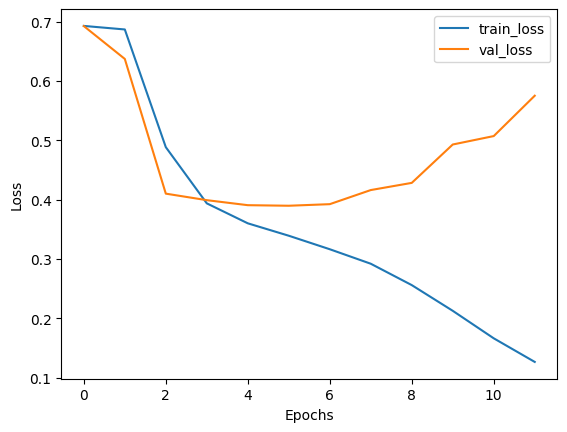

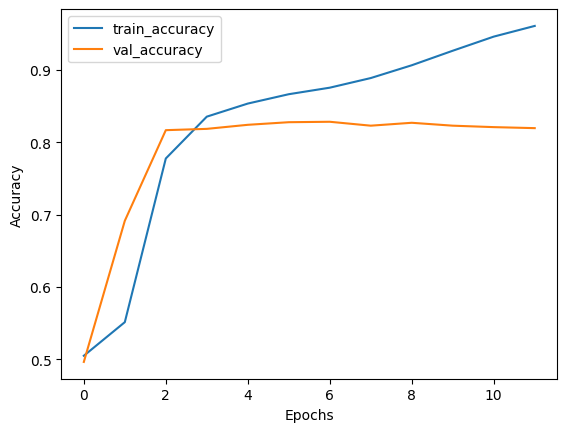

157/157 [==============================] - 4s 16ms/step - loss: 0.3857 - accuracy: 0.8268
[0.385711669921875, 0.8267999887466431]


In [ ]:
# Training 3 models for ensembling
model1 = train_full_model(train_seq,Y_train,val_seq,Y_val,test_seq,Y_test)
# model2 = train_full_model(train_seq,Y_train,val_seq,Y_val,test_seq,Y_test)
# model3 = train_full_model(train_seq,Y_train,val_seq,Y_val,test_seq,Y_test)